In [1]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-04-14 06:24:59.655139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 06:24:59.655235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 06:24:59.784560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# **Create needed functions**

### **Function to create dataframe from dataset**

In [2]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

### **Function to create image generators and augmentation**

In [3]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

### **Function that have Unet structure**

In [4]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### **Functions for coefficients and loss**

In [5]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### **Function to show images sample**

In [6]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

### **Function to display training history**

In [7]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Model Structure**

### **Start reading data**

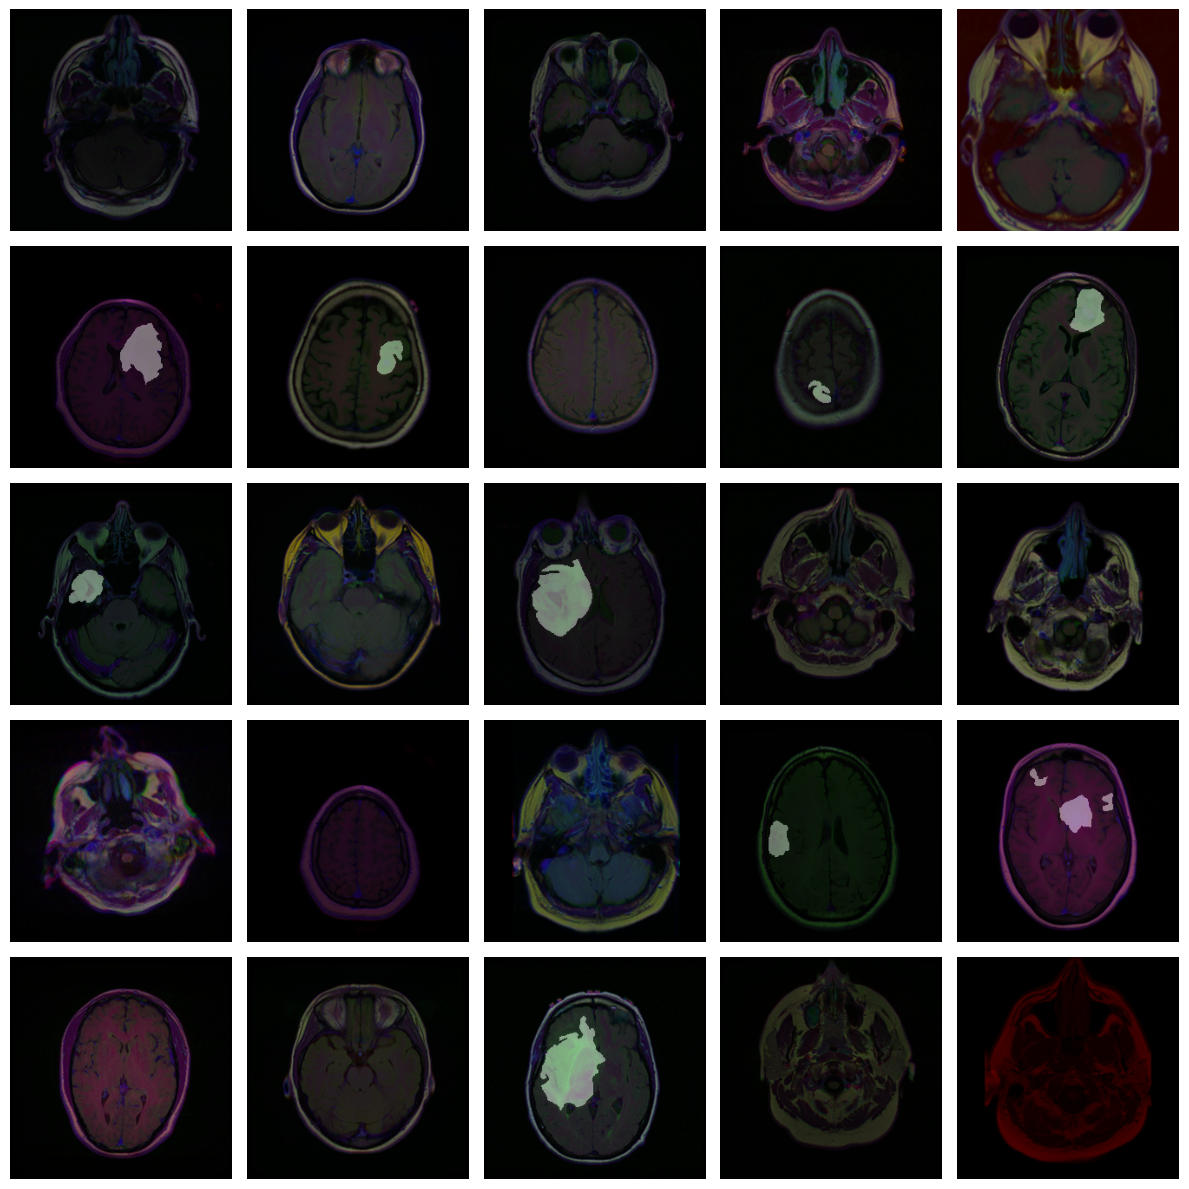

In [8]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

### **Unet Model**

In [9]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

### **Model training**

In [10]:
import math

epochs = 35
batch_size = 40
callbacks = [ModelCheckpoint('/kaggle/working/unet.keras', verbose=0, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=math.ceil(len(train_df) / batch_size),  # Ensure integer value
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=math.ceil(len(valid_df) / batch_size))  # Ensure integer value


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/35


2024-04-14 06:25:31.652543: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[40,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-14 06:25:31.808721: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65280: 2.08447, expected 1.77365
2024-04-14 06:25:31.808773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 2.14761, expected 1.73602
2024-04-14 06:25:31.808789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65557: 3.07515, expected 2.66355
2024-04-14 06:25:31.808808: E external/local_xla/xla/service/gpu/buffer_comparato

78/79 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8013 - dice_coef: 0.0760 - iou_coef: 0.0400 - loss: -0.0760

2024-04-14 06:29:22.028604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262144: 3.35871, expected 2.60945
2024-04-14 06:29:22.028665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262145: 4.26186, expected 3.5126
2024-04-14 06:29:22.028674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262146: 4.73703, expected 3.98777
2024-04-14 06:29:22.028682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262147: 5.44782, expected 4.69856
2024-04-14 06:29:22.028690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262148: 5.71942, expected 4.97017
2024-04-14 06:29:22.028698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262149: 6.34888, expected 5.59963
2024-04-14 06:29:22.028706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262150: 5.65648, expected 4.90722
2024-04-14 06:29:22.0

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8026 - dice_coef: 0.0765 - iou_coef: 0.0403 - loss: -0.0765Found 393 validated image filenames.
Found 393 validated image filenames.


2024-04-14 06:30:49.873932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.92132, expected 2.449
2024-04-14 06:30:49.873984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 2.95071, expected 2.47839
2024-04-14 06:30:49.873994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109: 3.19564, expected 2.72332
2024-04-14 06:30:49.874002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118: 3.67594, expected 3.20362
2024-04-14 06:30:49.874010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.53284, expected 3.06052
2024-04-14 06:30:49.874018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 3.648, expected 3.17568
2024-04-14 06:30:49.874026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 256: 3.64467, expected 3.17235
2024-04-14 06:30:49.874072: E external/local_xla

79/79 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.8040 - dice_coef: 0.0769 - iou_coef: 0.0405 - loss: -0.0769 - val_accuracy: 0.6593 - val_dice_coef: 0.0481 - val_iou_coef: 0.0247 - val_loss: -0.0481
Epoch 2/35
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 910ms/step - accuracy: 0.9816 - dice_coef: 0.2164 - iou_coef: 0.1240 - loss: -0.2164 - val_accuracy: 0.1322 - val_dice_coef: 0.0223 - val_iou_coef: 0.0113 - val_loss: -0.0223
Epoch 3/35
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 930ms/step - accuracy: 0.9914 - dice_coef: 0.4281 - iou_coef: 0.2805 - loss: -0.4281 - val_accuracy: 0.8720 - val_dice_coef: 0.1212 - val_iou_coef: 0.0651 - val_loss: -0.1212
Epoch 4/35
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 910ms/step - accuracy: 0.9934 - dice_coef: 0.6004 - iou_coef: 0.4390 - loss: -0.6004 - val_accuracy: 0.7947 - val_dice_coef: 0.0837 - val_iou_coef: 0.0439 - val_loss: -0.0837
Epoch 5/35
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 929ms/step - accuracy: 0.9935 - dice_coef: 0.6473 - iou_coef: 0.4854 - loss: -0.6473 - val_accuracy: 0.

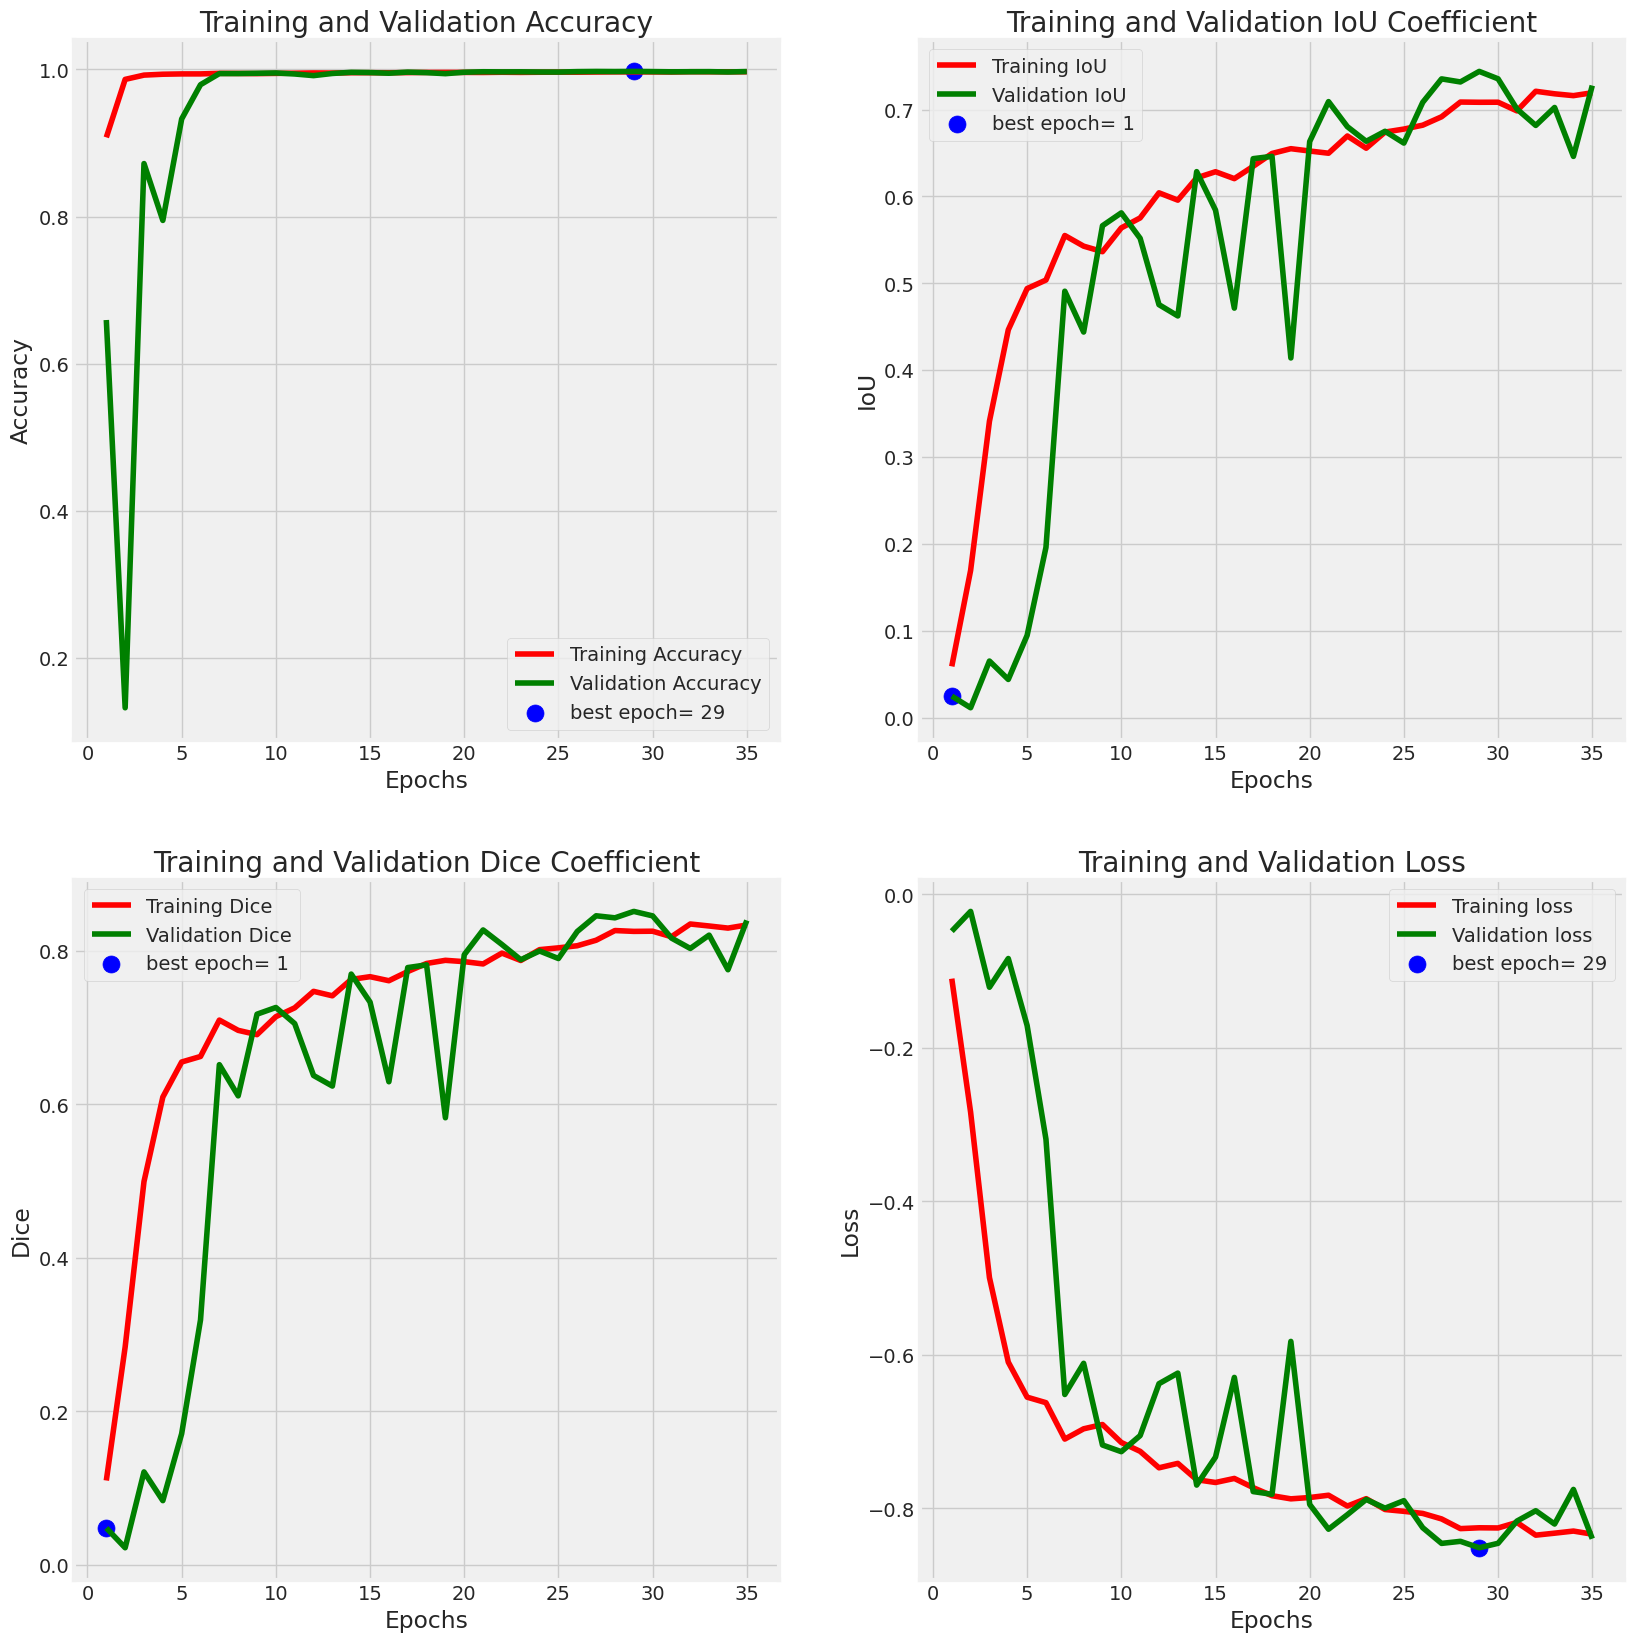

In [11]:
plot_training(history)

### **Model Evaluation**

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 724ms/step - accuracy: 0.9966 - dice_coef: 0.8385 - iou_coef: 0.7241 - loss: -0.8385
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.9970 - dice_coef: 0.8368 - iou_coef: 0.7266 - loss: -0.8368
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 303ms/step - accuracy: 0.9964 - dice_coef: 0.8191 - iou_coef: 0.7003 - loss: -0.8191
Train Loss:  -0.8345556855201721
Train Accuracy:  0.9965876340866089
Train IoU:  0.8345556855201721
Train Dice:  0.7190309166908264
--------------------
Valid Loss:  -0.8303738832473755
Valid Accuracy:  0.9968984723091125
Valid IoU:  0.8303738832473755
Valid Dice:  0.7185170650482178
--------------------
Test Loss:  -0.8117557168006897
Test Accuracy:  0.9963691234588623
Test IoU:  0.8117557168006897
Test Dice:  0.6924061179161072


# **Prediction**

2024-04-14 07:15:34.819236: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-04-14 07:15:34.819292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-04-14 07:15:34.819302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-04-14 07:15:34.819310: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-04-14 07:15:34.819318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-04-14 07:15:34.819327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-04-14 07:15:34.819335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-04-14 07:15:34.819343: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


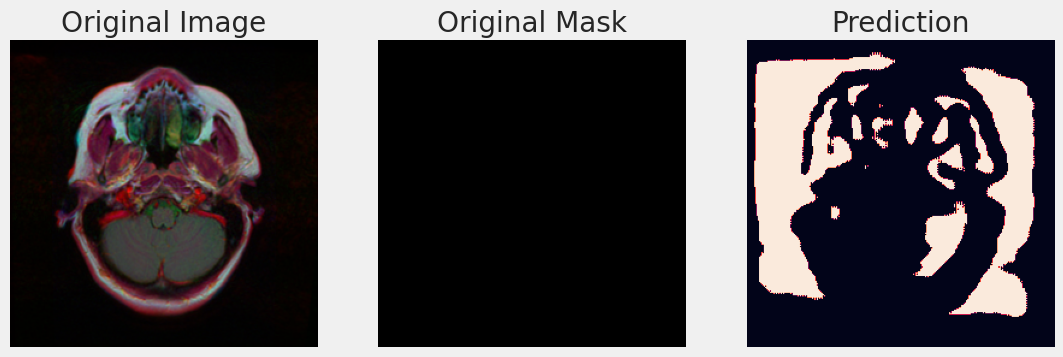

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


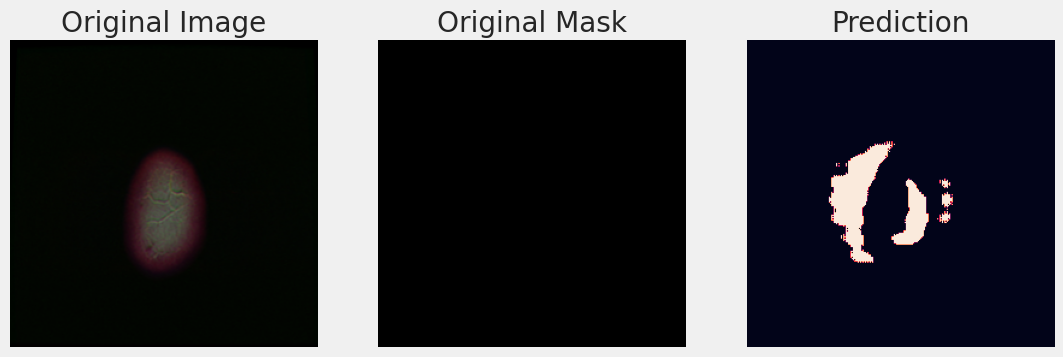

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


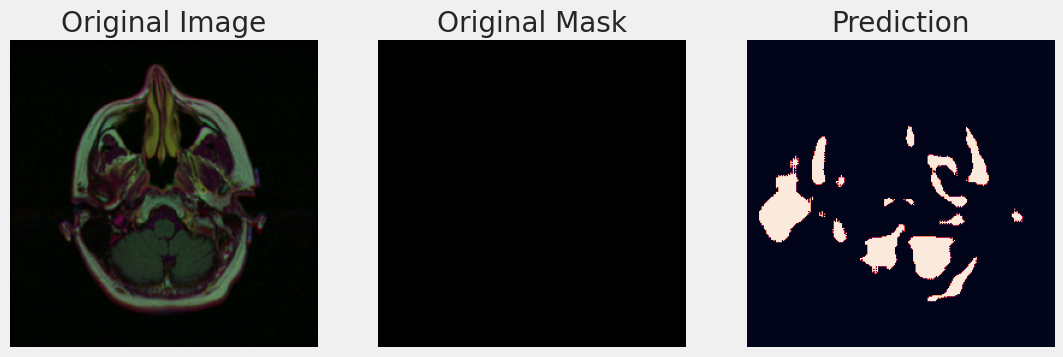

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


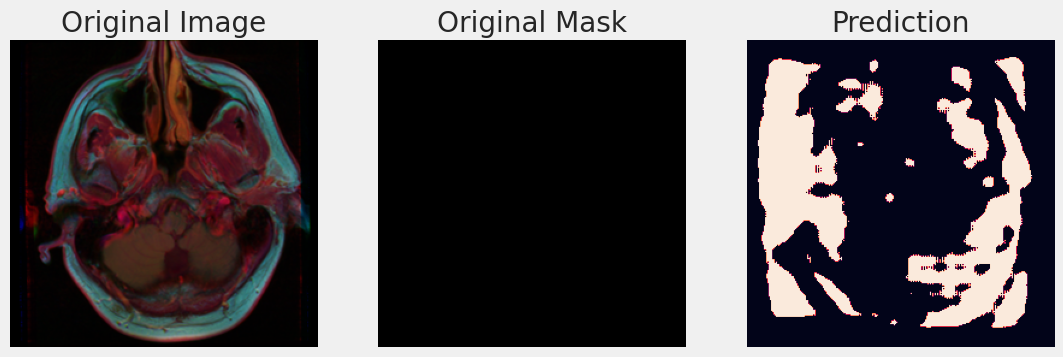

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


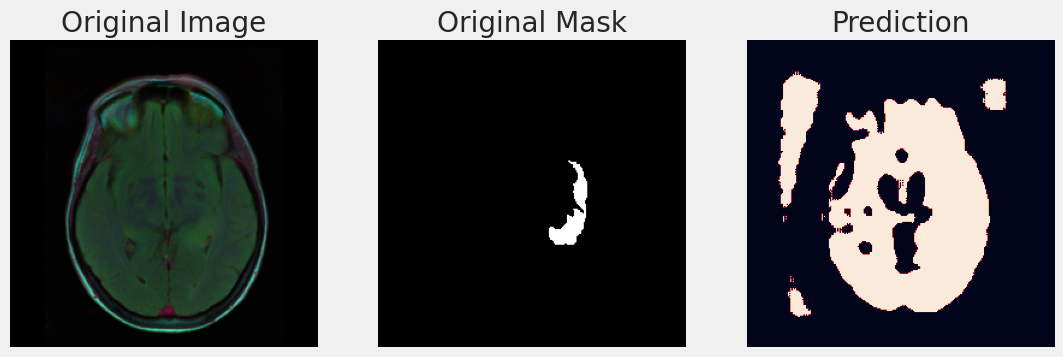

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


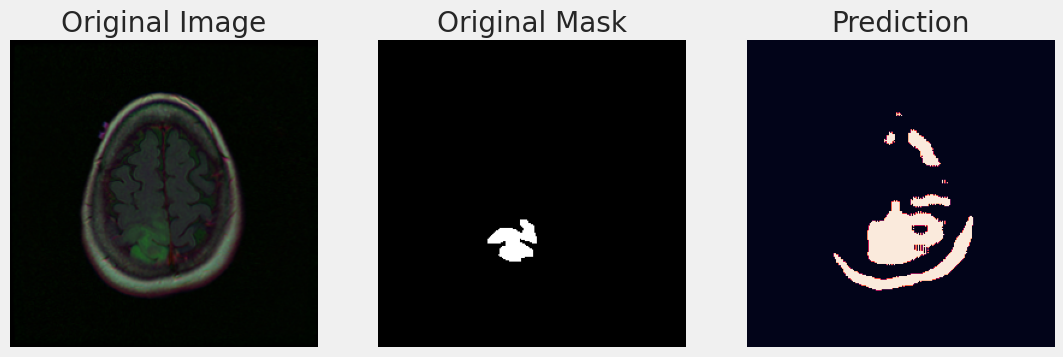

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


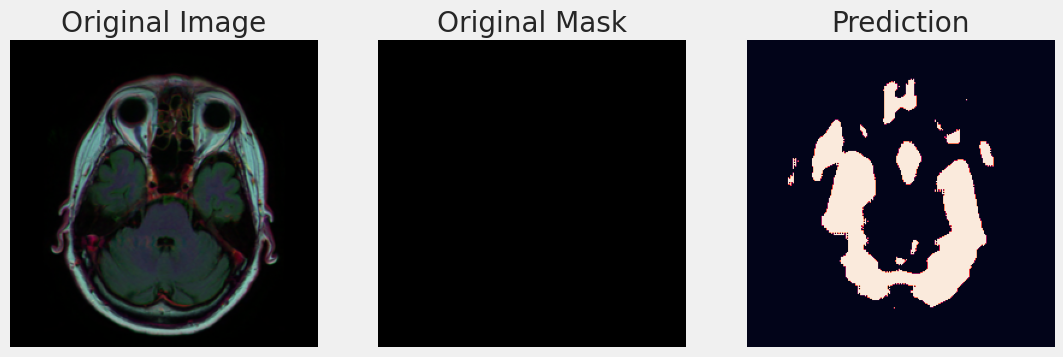

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


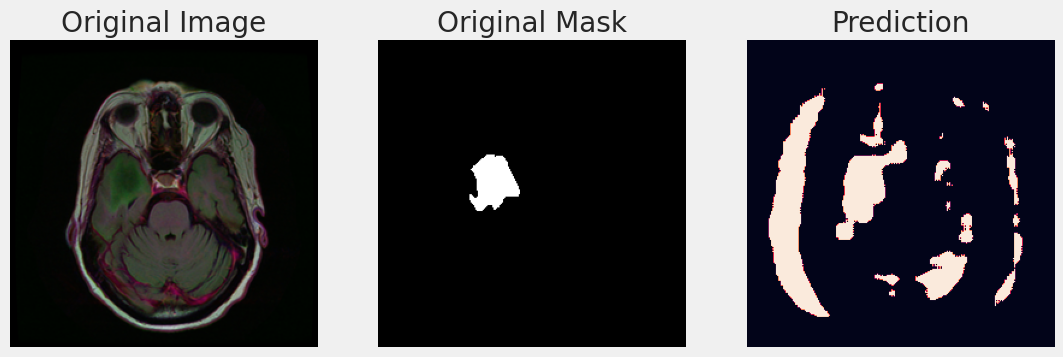

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


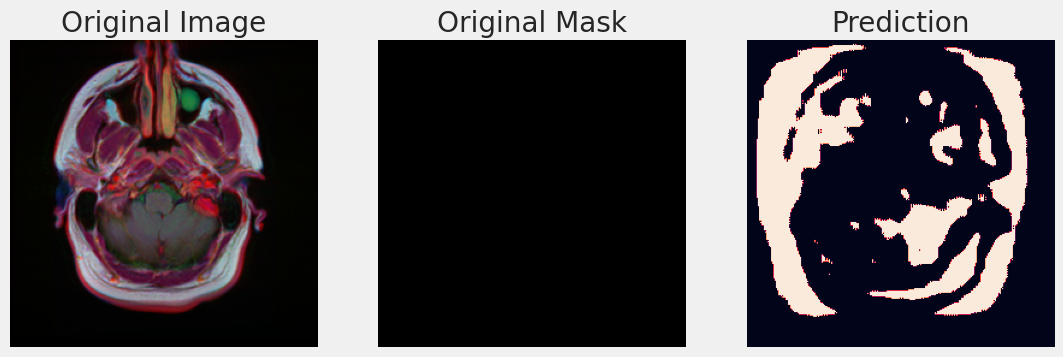

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


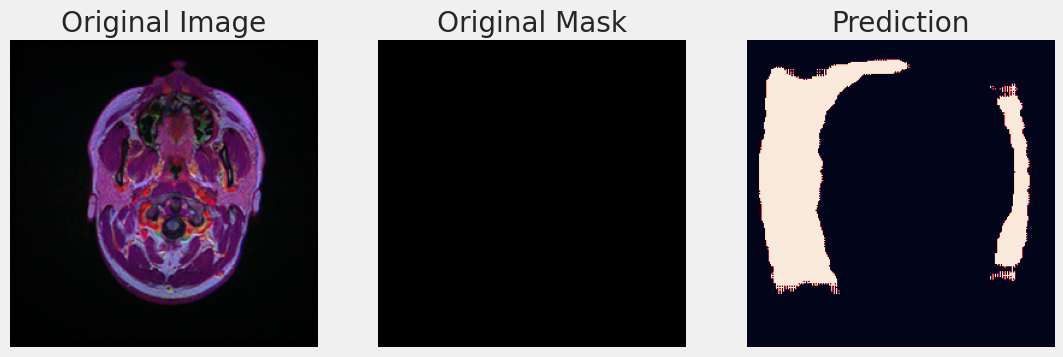

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


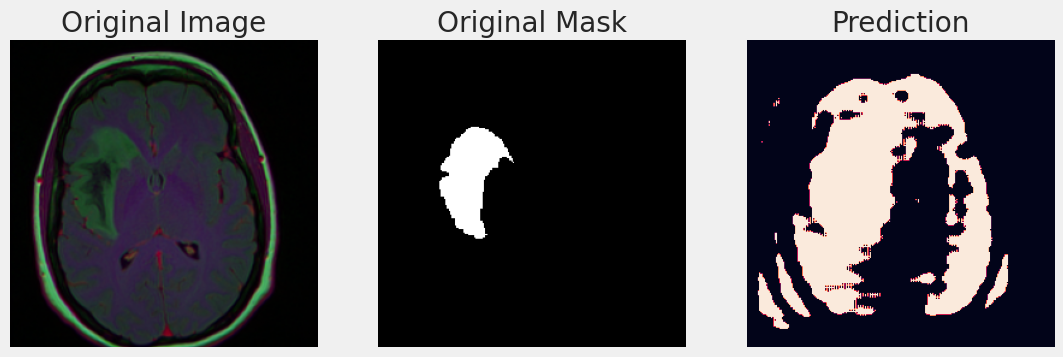

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


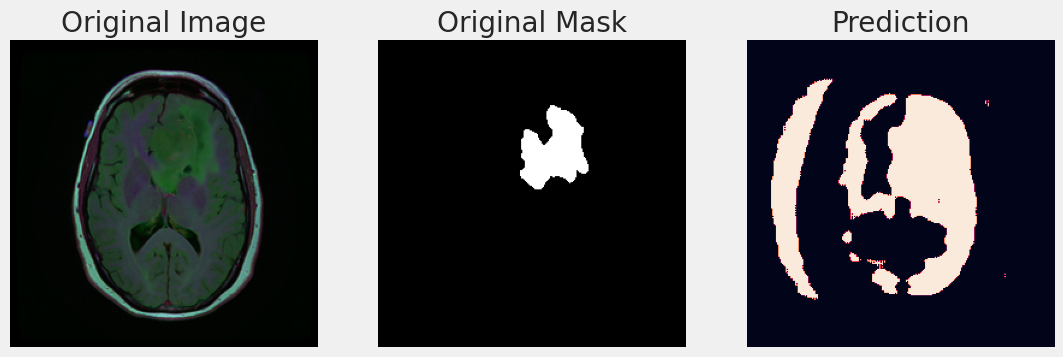

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


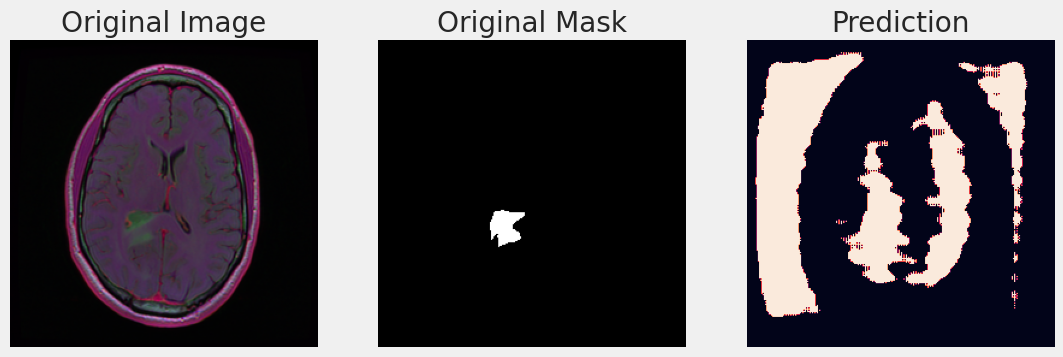

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


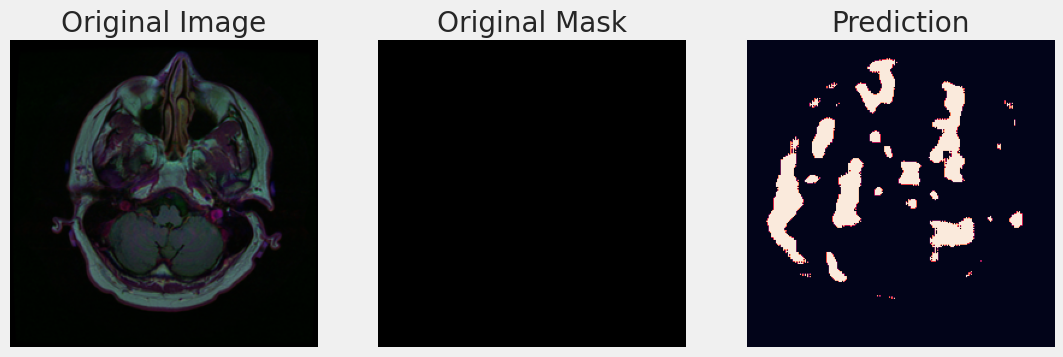

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


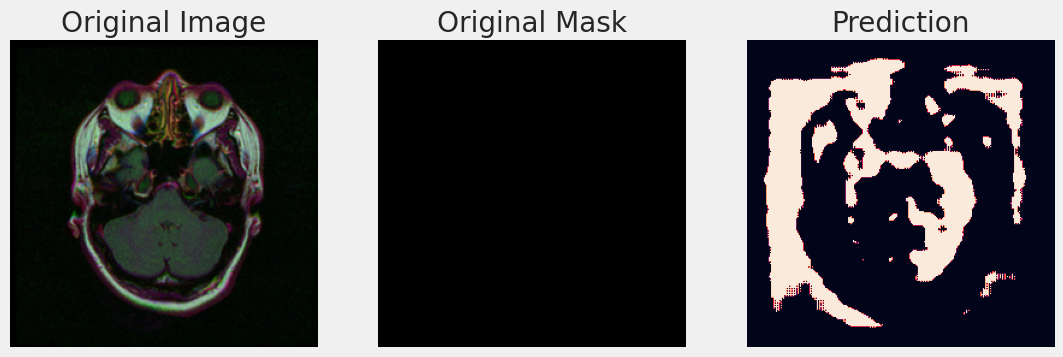

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


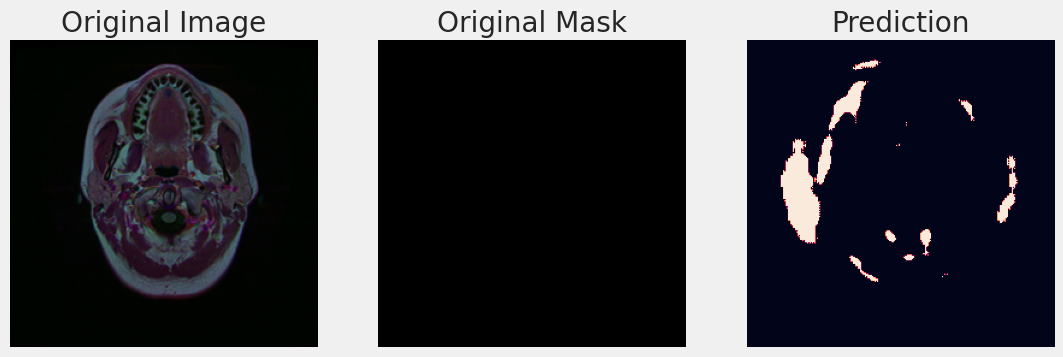

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


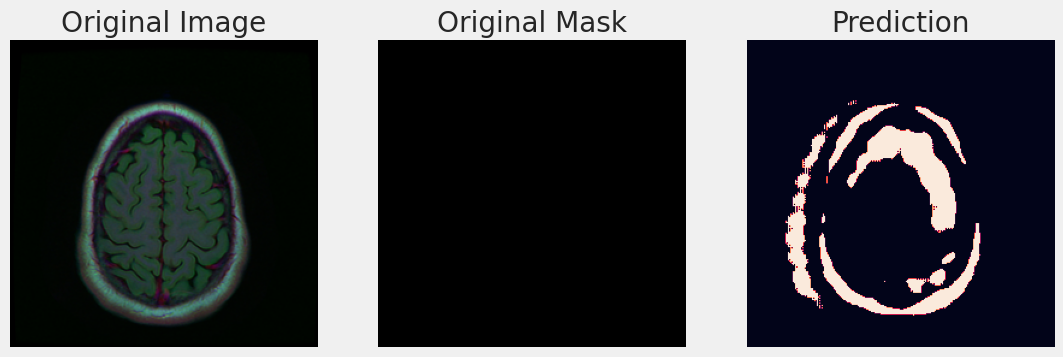

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


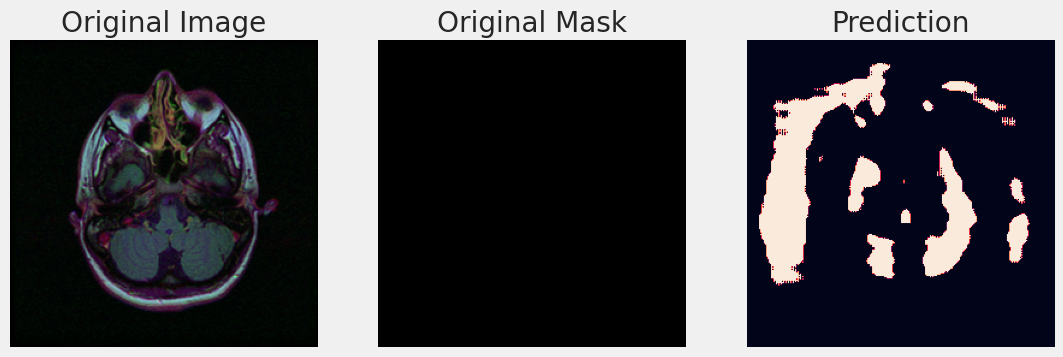

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


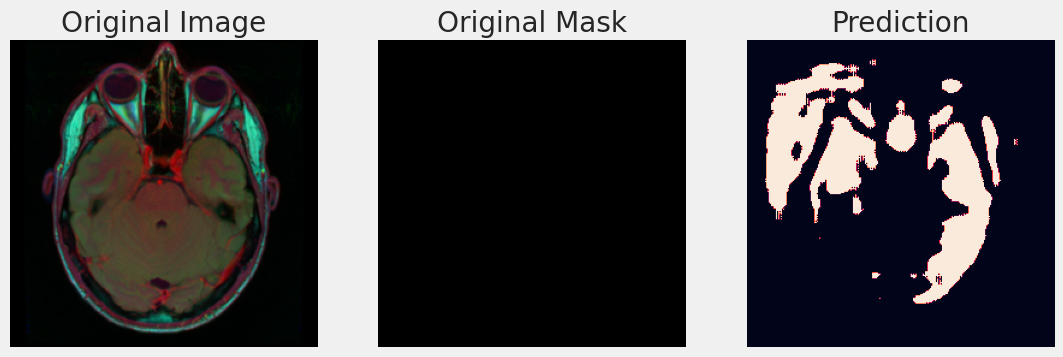

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


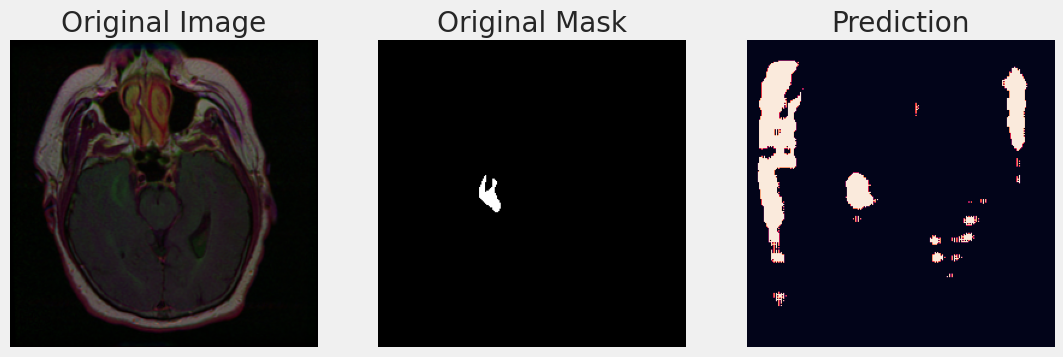

In [13]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()